In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

# **-------------------------------------Initial Preprocessing-------------------------------------**

In [ ]:
def preprocess_data(data):
    # Explicitly keep only the required columns
    required_columns = ['X', 'Seq', 'Proto', 'sDSb', 'dDSb', 'sTtl', 'sHops', 'Cause',
                        'TotPkts', 'SrcPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz',
                        'State', 'UniqueID', 'predicted', 'Label']

    # Drop columns that are not in the required list
    data = data[required_columns]

    # Convert non-numeric columns to numeric using LabelEncoder
    non_numeric_columns = data.select_dtypes(include=['object']).columns
    print(f"Non-numeric columns detected: {non_numeric_columns}")

    label_encoder = LabelEncoder()
    for col in non_numeric_columns:
        data[col] = label_encoder.fit_transform(data[col])
        print(f"Converted {col} to numerical values.")

    return data

# Load data
file_paths = [
    '/content/drive/MyDrive/5G-SliciNdd/URLLC.csv',
    '/content/drive/MyDrive/5G-SliciNdd/eMBB.csv',
    '/content/drive/MyDrive/5G-SliciNdd/mMTC.csv',
    '/content/drive/MyDrive/5G-SliciNdd/Global.csv'
]

for file_path in file_paths:
    data = pd.read_csv(file_path)
    print(f"Processing file: {file_path}")

    # Preprocess the data
    cleaned_data = preprocess_data(data)

    # Save the cleaned data to a new file
    cleaned_file_path = f"/content/drive/MyDrive/5G-SliciNdd/cleaned/{file_path.split('/')[-1].replace('.csv', '_cleaned.csv')}"
    cleaned_data.to_csv(cleaned_file_path, index=False)
    print(f"Saved cleaned data to: {cleaned_file_path}")


# **-------------------------------------------FL Models-------------------------------------------**

## **(1) FedAvg**


--- FedAvg Accuracies ---
Global Epoch 1: Accuracy = 0.4284
Global Epoch 2: Accuracy = 0.4484
Global Epoch 3: Accuracy = 0.4679
Global Epoch 4: Accuracy = 0.4846
Global Epoch 5: Accuracy = 0.5047
Global Epoch 6: Accuracy = 0.5318
Global Epoch 7: Accuracy = 0.5492
Global Epoch 8: Accuracy = 0.5596
Global Epoch 9: Accuracy = 0.5679
Global Epoch 10: Accuracy = 0.5779
Global Epoch 11: Accuracy = 0.5815
Global Epoch 12: Accuracy = 0.5902
Global Epoch 13: Accuracy = 0.5995
Global Epoch 14: Accuracy = 0.6065
Global Epoch 15: Accuracy = 0.6123
Global Epoch 16: Accuracy = 0.6237
Global Epoch 17: Accuracy = 0.6358
Global Epoch 18: Accuracy = 0.6489
Global Epoch 19: Accuracy = 0.6535
Global Epoch 20: Accuracy = 0.6618
Global Epoch 21: Accuracy = 0.6643
Global Epoch 22: Accuracy = 0.6665
Global Epoch 23: Accuracy = 0.6750
Global Epoch 24: Accuracy = 0.6818
Global Epoch 25: Accuracy = 0.6859
Global Epoch 26: Accuracy = 0.6889
Global Epoch 27: Accuracy = 0.6926
Global Epoch 28: Accuracy = 0.6952
Gl

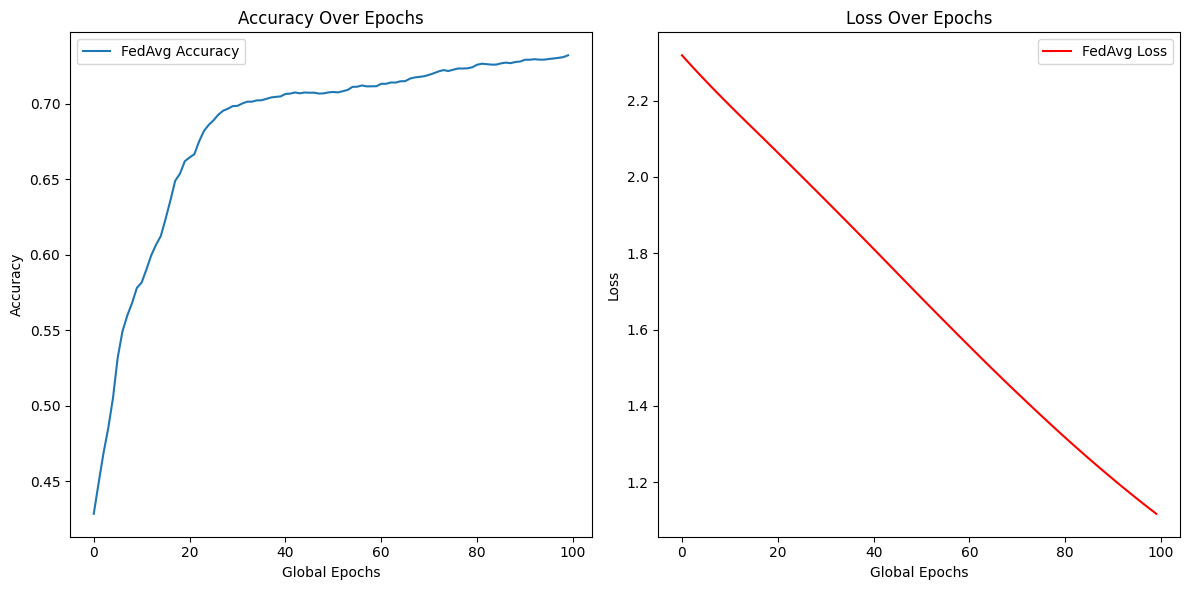

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

def preprocess_data(X, y):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    return X_tensor, y_tensor, scaler

class FedAvg:
    def __init__(self, model, num_clients, file_paths, lr=0.0001):
        self.model = model
        self.num_clients = num_clients
        self.file_paths = file_paths
        self.lr = lr
        self.clients = []
        self.scaler = None

        all_data = []
        for i in range(num_clients):
            df = pd.read_csv(file_paths[i])
            X = df.drop(columns=['Label'])
            y = df['Label']
            all_data.append((X, y))

        X_all = pd.concat([X for X, _ in all_data], axis=0)
        y_all = pd.concat([y for _, y in all_data], axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(X_all)

        for i in range(num_clients):
            X, y = all_data[i]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            X_train_tensor, y_train_tensor, _ = preprocess_data(X_train, y_train)
            X_test_tensor, y_test_tensor, _ = preprocess_data(X_test, y_test)

            self.clients.append(((X_train_tensor, y_train_tensor), (X_test_tensor, y_test_tensor)))

    def train_client(self, client_data):
        X_train, y_train = client_data

        client_model = MLP(input_size=X_train.shape[1], hidden_sizes=[100, 50], output_size=len(np.unique(y_train)))
        client_model.load_state_dict(self.model.state_dict())

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(client_model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

        client_losses = []  # Store losses during client training

        for epoch in range(5):
            client_model.train()
            optimizer.zero_grad()
            outputs = client_model(X_train)
            loss = criterion(outputs, y_train)

            if not torch.isfinite(loss):
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(client_model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            client_losses.append(loss.item())  # Append the loss for this epoch

        return client_model, client_losses

    def federated_averaging(self, client_models):
        with torch.no_grad():
            for global_param in self.model.parameters():
                global_param.data.zero_()
            for client_model in client_models:
                for global_param, client_param in zip(self.model.parameters(), client_model.parameters()):
                    global_param.data += client_param.data / len(client_models)

    def train(self, global_epochs=100):
        accuracies = []
        losses = []  # Track the global loss over epochs

        for global_epoch in range(global_epochs):
            client_models = []
            total_loss = 0  # Accumulate losses for each client

            for client_data in self.clients:
                train_data, _ = client_data
                client_model, client_loss = self.train_client(train_data)
                client_models.append(client_model)
                total_loss += sum(client_loss)  # Sum up the client losses

            # Perform federated averaging to update the global model
            self.federated_averaging(client_models)

            total_accuracy = 0

            # Compute average accuracy across all clients
            for i, client_data in enumerate(self.clients):
                _, test_data = client_data
                X_test, y_test = test_data
                accuracy = evaluate_accuracy(self.model, X_test, y_test)
                total_accuracy += accuracy

            avg_accuracy = total_accuracy / len(self.clients)
            avg_loss = total_loss / len(self.clients)

            accuracies.append(avg_accuracy)
            losses.append(avg_loss)  # Append average loss for the global epoch

        return accuracies, losses


def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

if __name__ == "__main__":
    file_paths = ['/content/drive/MyDrive/5G-SliciNdd/cleaned/URLLC_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/eMBB_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/mMTC_cleaned.csv']

    num_clients = len(file_paths)

    input_size = 17
    output_size = 2
    hidden_sizes = [100, 50]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    global_model_fedavg = MLP(input_size, hidden_sizes, output_size).to(device)
    fedavg = FedAvg(global_model_fedavg, num_clients=num_clients, file_paths=file_paths, lr=0.0001)

    fedavg_accuracies, fedavg_losses = fedavg.train(global_epochs=100)

    print("\n--- FedAvg Accuracies ---")
    for epoch, accuracy in enumerate(fedavg_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- FedAvg Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(fedavg_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"FedAvg Final Accuracy = {fedavg_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"FedAvg Average Loss over all epochs: {total_loss / len(fedavg_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(fedavg_accuracies, label='FedAvg Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(fedavg_losses, label='FedAvg Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


## **(2) FedProx**


--- FedProx Accuracies ---
Global Epoch 1: Accuracy = 0.6348
Global Epoch 2: Accuracy = 0.6679
Global Epoch 3: Accuracy = 0.6943
Global Epoch 4: Accuracy = 0.6916
Global Epoch 5: Accuracy = 0.7029
Global Epoch 6: Accuracy = 0.7231
Global Epoch 7: Accuracy = 0.7264
Global Epoch 8: Accuracy = 0.7359
Global Epoch 9: Accuracy = 0.7401
Global Epoch 10: Accuracy = 0.7393
Global Epoch 11: Accuracy = 0.7365
Global Epoch 12: Accuracy = 0.7348
Global Epoch 13: Accuracy = 0.7357
Global Epoch 14: Accuracy = 0.7360
Global Epoch 15: Accuracy = 0.7391
Global Epoch 16: Accuracy = 0.7423
Global Epoch 17: Accuracy = 0.7455
Global Epoch 18: Accuracy = 0.7472
Global Epoch 19: Accuracy = 0.7492
Global Epoch 20: Accuracy = 0.7518
Global Epoch 21: Accuracy = 0.7529
Global Epoch 22: Accuracy = 0.7531
Global Epoch 23: Accuracy = 0.7550
Global Epoch 24: Accuracy = 0.7548
Global Epoch 25: Accuracy = 0.7551
Global Epoch 26: Accuracy = 0.7574
Global Epoch 27: Accuracy = 0.7614
Global Epoch 28: Accuracy = 0.7636
G

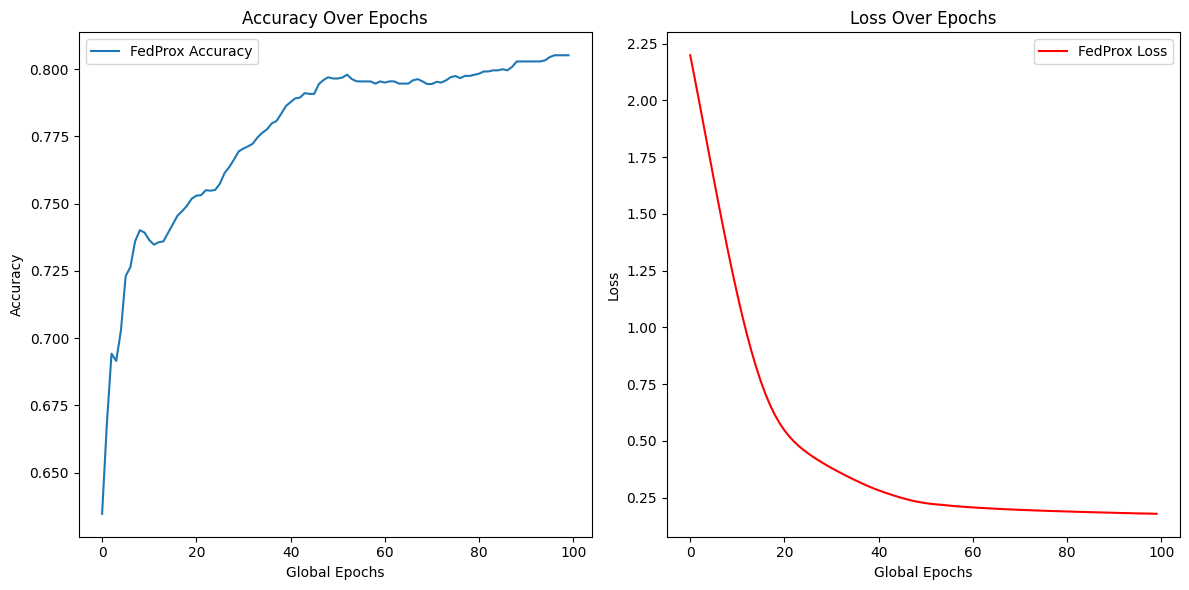

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

def preprocess_data(X, y):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    return X_tensor, y_tensor, scaler

class FedProx:
    def __init__(self, model, num_clients, file_paths, lr=0.001, mu=0.01):
        self.model = model
        self.num_clients = num_clients
        self.file_paths = file_paths
        self.lr = lr
        self.mu = mu
        self.clients = []
        self.scaler = None

        all_data = []
        for i in range(num_clients):
            df = pd.read_csv(file_paths[i])
            X = df.drop(columns=['Label'])
            y = df['Label']
            all_data.append((X, y))

        X_all = pd.concat([X for X, _ in all_data], axis=0)
        y_all = pd.concat([y for _, y in all_data], axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(X_all)

        for i in range(num_clients):
            X, y = all_data[i]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            X_train_tensor, y_train_tensor, _ = preprocess_data(X_train, y_train)
            X_test_tensor, y_test_tensor, _ = preprocess_data(X_test, y_test)

            self.clients.append(((X_train_tensor, y_train_tensor), (X_test_tensor, y_test_tensor)))

    def train_client(self, client_data, global_model):
        X_train, y_train = client_data

        client_model = MLP(input_size=X_train.shape[1], hidden_sizes=[100, 50], output_size=len(np.unique(y_train)))
        client_model.load_state_dict(global_model.state_dict())

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(client_model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

        client_losses = []  # Store losses during client training

        for epoch in range(5):
            client_model.train()
            optimizer.zero_grad()
            outputs = client_model(X_train)
            loss = criterion(outputs, y_train)

            # Add FedProx regularization term
            prox_loss = 0
            for param, global_param in zip(client_model.parameters(), global_model.parameters()):
                prox_loss += torch.sum((param - global_param) ** 2)
            loss += self.mu * prox_loss

            if not torch.isfinite(loss):
                # non-finite loss, ending training
                break

            loss.backward()

            torch.nn.utils.clip_grad_norm_(client_model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(loss)

            client_losses.append(loss.item())  # Append the loss for this epoch

        return client_model, client_losses

    def federated_averaging(self, client_models):
        with torch.no_grad():
            for global_param in self.model.parameters():
                global_param.data.zero_()
            for client_model in client_models:
                for global_param, client_param in zip(self.model.parameters(), client_model.parameters()):
                    global_param.data += client_param.data / len(client_models)

    def train(self, global_epochs=100):

        accuracies = []
        losses = []  # Track the global loss over epochs

        for global_epoch in range(global_epochs):
            client_models = []
            total_loss = 0  # Accumulate losses for each client
            for client_data in self.clients:
                train_data, _ = client_data
                client_model, client_loss = self.train_client(train_data, self.model)
                client_models.append(client_model)
                total_loss += sum(client_loss)  # Sum up the client losses

            self.federated_averaging(client_models)

            total_accuracy = 0

            for i, client_data in enumerate(self.clients):
                _, test_data = client_data
                X_test, y_test = test_data
                accuracy = evaluate_accuracy(self.model, X_test, y_test)
                total_accuracy += accuracy

            avg_accuracy = total_accuracy / len(self.clients)
            accuracies.append(avg_accuracy)

            avg_loss = total_loss / len(self.clients)
            losses.append(avg_loss)  # Append average loss for the global epoch

        return accuracies, losses

def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

if __name__ == "__main__":
    file_paths = ['/content/drive/MyDrive/5G-SliciNdd/cleaned/URLLC_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/eMBB_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/mMTC_cleaned.csv']

    num_clients = len(file_paths)
    input_size = 17
    output_size = 2
    hidden_sizes = [100, 50]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    global_model_fedprox = MLP(input_size, hidden_sizes, output_size).to(device)
    fedprox = FedProx(global_model_fedprox, num_clients=num_clients, file_paths=file_paths, lr=0.001, mu=0.01)

    fedprox_accuracies, fedprox_losses = fedprox.train(global_epochs=100)

    print("\n--- FedProx Accuracies ---")
    for epoch, accuracy in enumerate(fedprox_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- FedProx Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(fedprox_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"FedProx Final Accuracy = {fedprox_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"FedProx Average Loss over all epochs: {total_loss / len(fedprox_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(fedprox_accuracies, label='FedProx Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(fedprox_losses, label='FedProx Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **(3) FedDyn**


--- FedDyn Accuracies ---
Global Epoch 1: Accuracy = 0.4844
Global Epoch 2: Accuracy = 0.5478
Global Epoch 3: Accuracy = 0.6410
Global Epoch 4: Accuracy = 0.6651
Global Epoch 5: Accuracy = 0.6728
Global Epoch 6: Accuracy = 0.7114
Global Epoch 7: Accuracy = 0.7132
Global Epoch 8: Accuracy = 0.7101
Global Epoch 9: Accuracy = 0.7180
Global Epoch 10: Accuracy = 0.7293
Global Epoch 11: Accuracy = 0.7351
Global Epoch 12: Accuracy = 0.7377
Global Epoch 13: Accuracy = 0.7419
Global Epoch 14: Accuracy = 0.7464
Global Epoch 15: Accuracy = 0.7488
Global Epoch 16: Accuracy = 0.7547
Global Epoch 17: Accuracy = 0.7568
Global Epoch 18: Accuracy = 0.7579
Global Epoch 19: Accuracy = 0.7557
Global Epoch 20: Accuracy = 0.7577
Global Epoch 21: Accuracy = 0.7577
Global Epoch 22: Accuracy = 0.7583
Global Epoch 23: Accuracy = 0.7580
Global Epoch 24: Accuracy = 0.7608
Global Epoch 25: Accuracy = 0.7623
Global Epoch 26: Accuracy = 0.7667
Global Epoch 27: Accuracy = 0.7702
Global Epoch 28: Accuracy = 0.7716
Gl

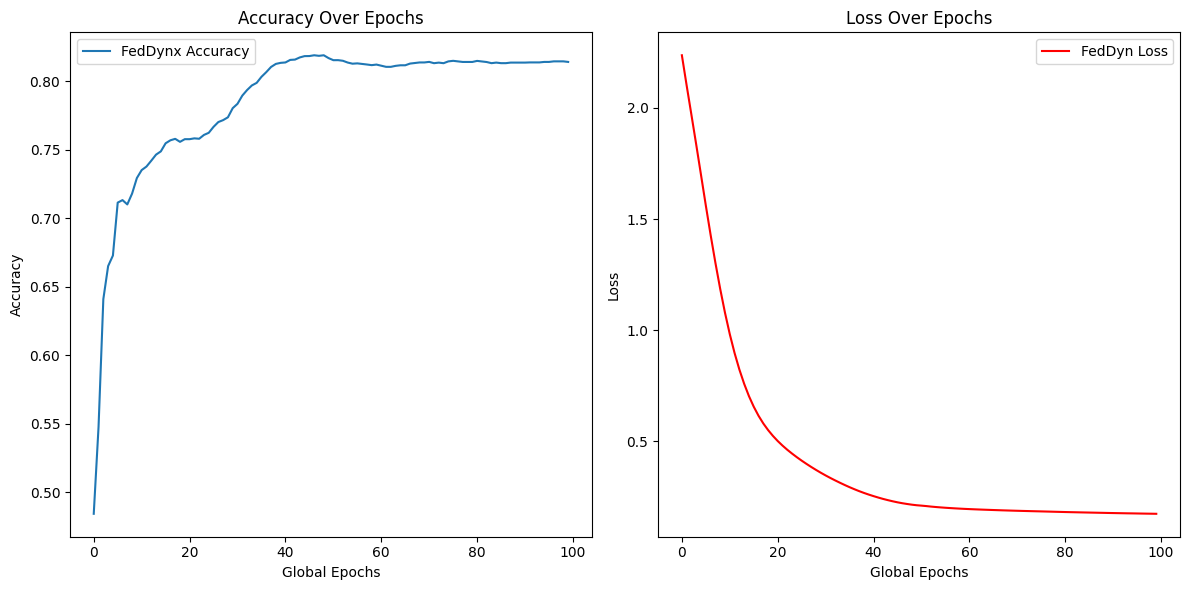

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)
        return self.model(x)


def preprocess_data(X, y):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    return X_tensor, y_tensor, scaler

class FedDyn:
    def __init__(self, model, num_clients, file_paths, lr=0.001, lambda_reg=0.01):
        self.model = model
        self.num_clients = num_clients
        self.file_paths = file_paths
        self.lr = lr
        self.lambda_reg = lambda_reg
        self.clients = []
        self.scaler = None

        all_data = []
        for i in range(num_clients):
            df = pd.read_csv(file_paths[i])
            X = df.drop(columns=['Label'])
            y = df['Label']
            all_data.append((X, y))

        X_all = pd.concat([X for X, _ in all_data], axis=0)
        y_all = pd.concat([y for _, y in all_data], axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(X_all)

        for i in range(num_clients):
            X, y = all_data[i]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            X_train_tensor, y_train_tensor, _ = preprocess_data(X_train, y_train)
            X_test_tensor, y_test_tensor, _ = preprocess_data(X_test, y_test)

            self.clients.append(((X_train_tensor, y_train_tensor), (X_test_tensor, y_test_tensor)))

    def dynamic_regularization_loss(self, local_model, global_model, X_local, y_local):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(local_model(X_local), y_local)  # Standard loss
        regularizer = 0
        for local_param, global_param in zip(local_model.parameters(), global_model.parameters()):
            regularizer += torch.sum((local_param - global_param) ** 2)  # Regularization term
        return loss + self.lambda_reg * regularizer

    def train_client(self, client_data, global_model):
        X_train, y_train = client_data

        client_model = MLP(input_size=X_train.shape[1], hidden_sizes=[100, 50], output_size=len(np.unique(y_train)))
        client_model.load_state_dict(global_model.state_dict())

        optimizer = optim.AdamW(client_model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

        client_losses = []  # Store losses during client training

        for epoch in range(5):
            client_model.train()
            optimizer.zero_grad()
            loss = self.dynamic_regularization_loss(client_model, global_model, X_train, y_train)

            if not torch.isfinite(loss):
                # non-finite loss, ending training
                break

            loss.backward()

            torch.nn.utils.clip_grad_norm_(client_model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(loss)
            client_losses.append(loss.item())  # Append the loss for this epoch


        return client_model, client_losses

    def federated_averaging(self, client_models):
        with torch.no_grad():
            for global_param in self.model.parameters():
                global_param.data.zero_()
            for client_model in client_models:
                for global_param, client_param in zip(self.model.parameters(), client_model.parameters()):
                    global_param.data += client_param.data / len(client_models)

    def train(self, global_epochs=100):

        accuracies = []
        losses = []  # Track the global loss over epochs

        for global_epoch in range(global_epochs):
            client_models = []
            total_loss = 0  # Accumulate losses for each client
            for client_data in self.clients:
                train_data, _ = client_data
                client_model, client_loss = self.train_client(train_data, self.model)
                client_models.append(client_model)
                total_loss += sum(client_loss)  # Sum up the client losses

            self.federated_averaging(client_models)

            total_accuracy = 0

            for i, client_data in enumerate(self.clients):
                _, test_data = client_data
                X_test, y_test = test_data
                accuracy = evaluate_accuracy(self.model, X_test, y_test)
                total_accuracy += accuracy

            avg_accuracy = total_accuracy / len(self.clients)
            accuracies.append(avg_accuracy)

            avg_loss = total_loss / len(self.clients)
            losses.append(avg_loss)  # Append average loss for the global epoch

        return accuracies, losses

def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

if __name__ == "__main__":
    file_paths = ['/content/drive/MyDrive/5G-SliciNdd/cleaned/URLLC_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/eMBB_cleaned.csv',
                  '/content/drive/MyDrive/5G-SliciNdd/cleaned/mMTC_cleaned.csv']

    num_clients = len(file_paths)
    input_size = 17
    output_size = 2
    hidden_sizes = [100, 50]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    global_model_feddyn = MLP(input_size, hidden_sizes, output_size).to(device)
    feddyn = FedDyn(global_model_feddyn, num_clients=num_clients, file_paths=file_paths, lr=0.001, lambda_reg=0.01)

    feddyn_accuracies, feddyn_losses = feddyn.train(global_epochs=100)

    print("\n--- FedDyn Accuracies ---")
    for epoch, accuracy in enumerate(feddyn_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- FedDyn Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(feddyn_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"FedDyn Final Accuracy = {feddyn_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"FedDyn Average Loss over all epochs: {total_loss / len(feddyn_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(feddyn_accuracies, label='FedDynx Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(feddyn_losses, label='FedDyn Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **----------------------------------------Local Models----------------------------------------**

## **(1) URLLC Client**


--- Client 1 Local Accuracies ---
Global Epoch 1: Accuracy = 0.4077
Global Epoch 2: Accuracy = 0.5651
Global Epoch 3: Accuracy = 0.7485
Global Epoch 4: Accuracy = 0.8401
Global Epoch 5: Accuracy = 0.8947
Global Epoch 6: Accuracy = 0.9269
Global Epoch 7: Accuracy = 0.9529
Global Epoch 8: Accuracy = 0.9628
Global Epoch 9: Accuracy = 0.9678
Global Epoch 10: Accuracy = 0.9690
Global Epoch 11: Accuracy = 0.9715
Global Epoch 12: Accuracy = 0.9703
Global Epoch 13: Accuracy = 0.9715
Global Epoch 14: Accuracy = 0.9740
Global Epoch 15: Accuracy = 0.9740
Global Epoch 16: Accuracy = 0.9740
Global Epoch 17: Accuracy = 0.9727
Global Epoch 18: Accuracy = 0.9715
Global Epoch 19: Accuracy = 0.9715
Global Epoch 20: Accuracy = 0.9715
Global Epoch 21: Accuracy = 0.9715
Global Epoch 22: Accuracy = 0.9715
Global Epoch 23: Accuracy = 0.9715
Global Epoch 24: Accuracy = 0.9715
Global Epoch 25: Accuracy = 0.9715
Global Epoch 26: Accuracy = 0.9715
Global Epoch 27: Accuracy = 0.9715
Global Epoch 28: Accuracy = 0

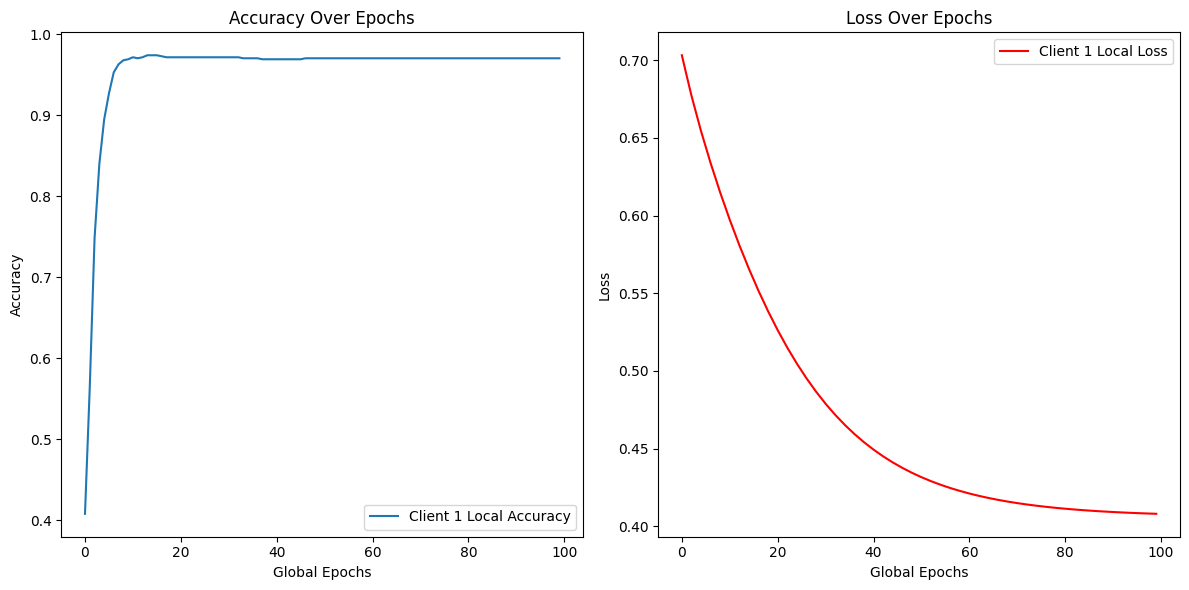

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)


# Function to evaluate accuracy
def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

#  local model training class
class LocalModel:
    def __init__(self, model, file_path, lr=0.0001):
        self.model = model
        self.lr = lr
        self.file_path = file_path
        self.scaler = None

        df = pd.read_csv(file_path)
        X = df.drop('Label', axis=1)
        y = df['Label']

        # Initialize LabelEncoder to convert categorical data into numeric labels
        le = LabelEncoder()

        # 1. Process categorical features (if any) in the feature matrix X
        for column in X.columns:
            # Check if the column is categorical (i.e., object data type)
            if X[column].dtype == 'object':
                # Step 1a: Handle missing values by filling them with 'Unknown'
                X[column] = X[column].fillna('Unknown')
                # Step 1b: Encode categorical values as numeric labels
                X[column] = le.fit_transform(X[column].astype(str))  # Ensure values are treated as strings before encoding

        # 2. Impute missing values in numerical columns with the median value of each column
        num_columns = X.select_dtypes(include=['int64', 'float64']).columns  # Select numerical columns (int or float)

        # Initialize SimpleImputer to fill missing values with the median strategy
        imputer = SimpleImputer(strategy='median')
        # Apply the imputer to numerical columns and replace missing values
        X[num_columns] = imputer.fit_transform(X[num_columns])

        # 3. Standardize numerical features: Scale them to have mean=0 and variance=1
        scaler = StandardScaler()
        # Scale all columns of X (this will affect both categorical and numerical columns)
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        # 4. Encode the target variable y (if categorical)
        # Convert categorical labels into numeric values (e.g., 'Benign' -> 0, 'Malicious' -> 1)
        y = le.fit_transform(y)  # We use the same encoder to ensure consistency between X and y encoding


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.LongTensor(y_test)

        self.X_train = X_train_tensor
        self.y_train = y_train_tensor
        self.X_test = X_test_tensor
        self.y_test = y_test_tensor

    def train(self, epochs=100):
        accuracies = []
        losses = []  # Track the global loss over epochs
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

        # Training loop
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train)
            loss = criterion(outputs, self.y_train)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = evaluate_accuracy(self.model, self.X_test, self.y_test)
            accuracies.append(accuracy)
            losses.append(loss.item())


        return accuracies, losses

if __name__ == "__main__":

    file_path = '/content/drive/MyDrive/5G-SliciNdd/cleaned/URLLC_cleaned.csv'

    # MLP model configuration
    input_size = 17  # Adjust based on your dataset
    output_size = 2  # Adjust for the number of classes
    hidden_sizes = [100, 50]  # Example hidden layer sizes

    # Initialize the MLP model
    model = MLP(input_size, hidden_sizes, output_size).to(device)

    # Initialize the local training object
    client1_model = LocalModel(model, file_path, lr=0.001)

    # Train the model and get the accuracy results
    client1_accuracies, client1_losses = client1_model.train(epochs=100)


    print("\n--- Client 1 Local Accuracies ---")
    for epoch, accuracy in enumerate(client1_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- Client 1 Local Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(client1_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"Client 1 Local Final Accuracy = {client1_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"Client 1 Local Average Loss over all epochs: {total_loss / len(client1_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(client1_accuracies, label='Client 1 Local Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(client1_losses, label='Client 1 Local Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **(2) eMBB Client**


--- Client 2 Local Accuracies ---
Global Epoch 1: Accuracy = 0.4682
Global Epoch 2: Accuracy = 0.5826
Global Epoch 3: Accuracy = 0.7212
Global Epoch 4: Accuracy = 0.8021
Global Epoch 5: Accuracy = 0.8408
Global Epoch 6: Accuracy = 0.8657
Global Epoch 7: Accuracy = 0.8769
Global Epoch 8: Accuracy = 0.9225
Global Epoch 9: Accuracy = 0.9441
Global Epoch 10: Accuracy = 0.9432
Global Epoch 11: Accuracy = 0.9432
Global Epoch 12: Accuracy = 0.9423
Global Epoch 13: Accuracy = 0.9423
Global Epoch 14: Accuracy = 0.9423
Global Epoch 15: Accuracy = 0.9423
Global Epoch 16: Accuracy = 0.9415
Global Epoch 17: Accuracy = 0.9423
Global Epoch 18: Accuracy = 0.9432
Global Epoch 19: Accuracy = 0.9432
Global Epoch 20: Accuracy = 0.9432
Global Epoch 21: Accuracy = 0.9432
Global Epoch 22: Accuracy = 0.9432
Global Epoch 23: Accuracy = 0.9432
Global Epoch 24: Accuracy = 0.9432
Global Epoch 25: Accuracy = 0.9432
Global Epoch 26: Accuracy = 0.9432
Global Epoch 27: Accuracy = 0.9432
Global Epoch 28: Accuracy = 0

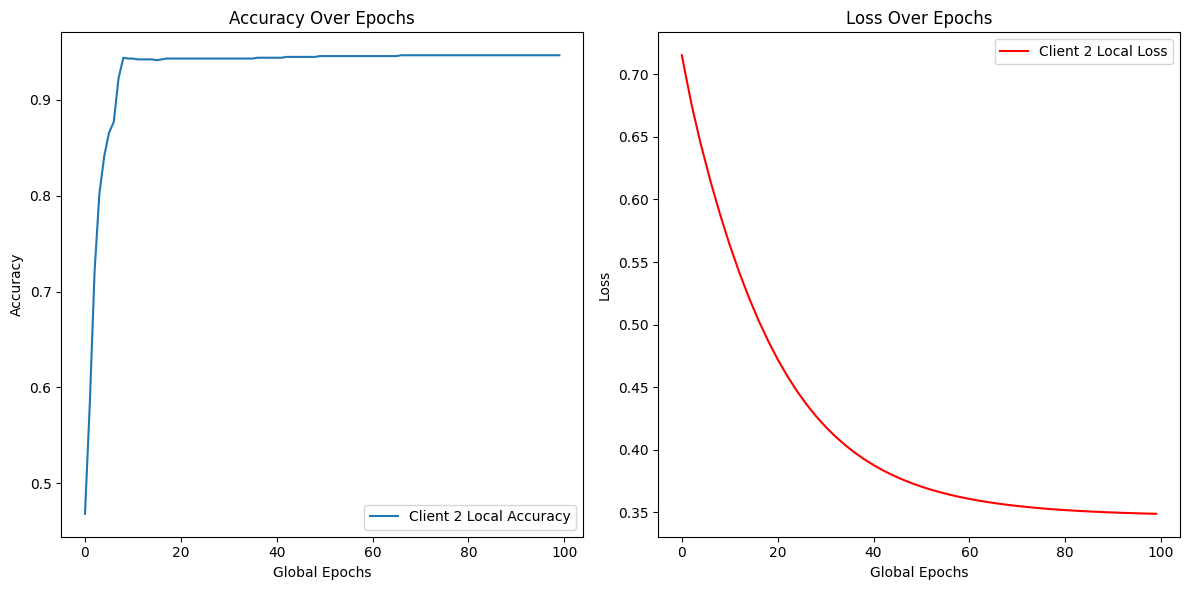

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)


# Function to evaluate accuracy
def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

#  local model training class
class LocalModel:
    def __init__(self, model, file_path, lr=0.0001):
        self.model = model
        self.lr = lr
        self.file_path = file_path
        self.scaler = None

        df = pd.read_csv(file_path)
        X = df.drop('Label', axis=1)
        y = df['Label']

        # Initialize LabelEncoder to convert categorical data into numeric labels
        le = LabelEncoder()

        # 1. Process categorical features (if any) in the feature matrix X
        for column in X.columns:
            # Check if the column is categorical (i.e., object data type)
            if X[column].dtype == 'object':
                # Step 1a: Handle missing values by filling them with 'Unknown'
                X[column] = X[column].fillna('Unknown')
                # Step 1b: Encode categorical values as numeric labels
                X[column] = le.fit_transform(X[column].astype(str))  # Ensure values are treated as strings before encoding

        # 2. Impute missing values in numerical columns with the median value of each column
        num_columns = X.select_dtypes(include=['int64', 'float64']).columns  # Select numerical columns (int or float)

        # Initialize SimpleImputer to fill missing values with the median strategy
        imputer = SimpleImputer(strategy='median')
        # Apply the imputer to numerical columns and replace missing values
        X[num_columns] = imputer.fit_transform(X[num_columns])

        # 3. Standardize numerical features: Scale them to have mean=0 and variance=1
        scaler = StandardScaler()
        # Scale all columns of X (this will affect both categorical and numerical columns)
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        # 4. Encode the target variable y (if categorical)
        # Convert categorical labels into numeric values (e.g., 'Benign' -> 0, 'Malicious' -> 1)
        y = le.fit_transform(y)  # We use the same encoder to ensure consistency between X and y encoding


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.LongTensor(y_test)

        self.X_train = X_train_tensor
        self.y_train = y_train_tensor
        self.X_test = X_test_tensor
        self.y_test = y_test_tensor

    def train(self, epochs=100):
        accuracies = []
        losses = []  # Track the global loss over epochs
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

        # Training loop
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train)
            loss = criterion(outputs, self.y_train)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = evaluate_accuracy(self.model, self.X_test, self.y_test)
            accuracies.append(accuracy)
            losses.append(loss.item())


        return accuracies, losses

if __name__ == "__main__":

    file_path = '/content/drive/MyDrive/5G-SliciNdd/cleaned/eMBB_cleaned.csv'

    # MLP model configuration
    input_size = 17  # Adjust based on your dataset
    output_size = 2  # Adjust for the number of classes
    hidden_sizes = [100, 50]  # Example hidden layer sizes

    # Initialize the MLP model
    model = MLP(input_size, hidden_sizes, output_size).to(device)

    # Initialize the local training object
    client2_model = LocalModel(model, file_path, lr=0.001)

    # Train the model and get the accuracy results
    client2_accuracies, client2_losses = client2_model.train(epochs=100)


    print("\n--- Client 2 Local Accuracies ---")
    for epoch, accuracy in enumerate(client2_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- Client 2 Local Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(client2_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"Client 2 Local Final Accuracy = {client2_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"Client 2 Local Average Loss over all epochs: {total_loss / len(client2_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(client2_accuracies, label='Client 2 Local Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(client2_losses, label='Client 2 Local Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **(3) mMTC Client**


--- Client 3 Local Accuracies ---
Global Epoch 1: Accuracy = 0.6641
Global Epoch 2: Accuracy = 0.6912
Global Epoch 3: Accuracy = 0.7129
Global Epoch 4: Accuracy = 0.7714
Global Epoch 5: Accuracy = 0.8288
Global Epoch 6: Accuracy = 0.8635
Global Epoch 7: Accuracy = 0.9079
Global Epoch 8: Accuracy = 0.9242
Global Epoch 9: Accuracy = 0.9415
Global Epoch 10: Accuracy = 0.9480
Global Epoch 11: Accuracy = 0.9523
Global Epoch 12: Accuracy = 0.9523
Global Epoch 13: Accuracy = 0.9491
Global Epoch 14: Accuracy = 0.9469
Global Epoch 15: Accuracy = 0.9480
Global Epoch 16: Accuracy = 0.9491
Global Epoch 17: Accuracy = 0.9491
Global Epoch 18: Accuracy = 0.9491
Global Epoch 19: Accuracy = 0.9469
Global Epoch 20: Accuracy = 0.9469
Global Epoch 21: Accuracy = 0.9458
Global Epoch 22: Accuracy = 0.9458
Global Epoch 23: Accuracy = 0.9458
Global Epoch 24: Accuracy = 0.9458
Global Epoch 25: Accuracy = 0.9458
Global Epoch 26: Accuracy = 0.9458
Global Epoch 27: Accuracy = 0.9458
Global Epoch 28: Accuracy = 0

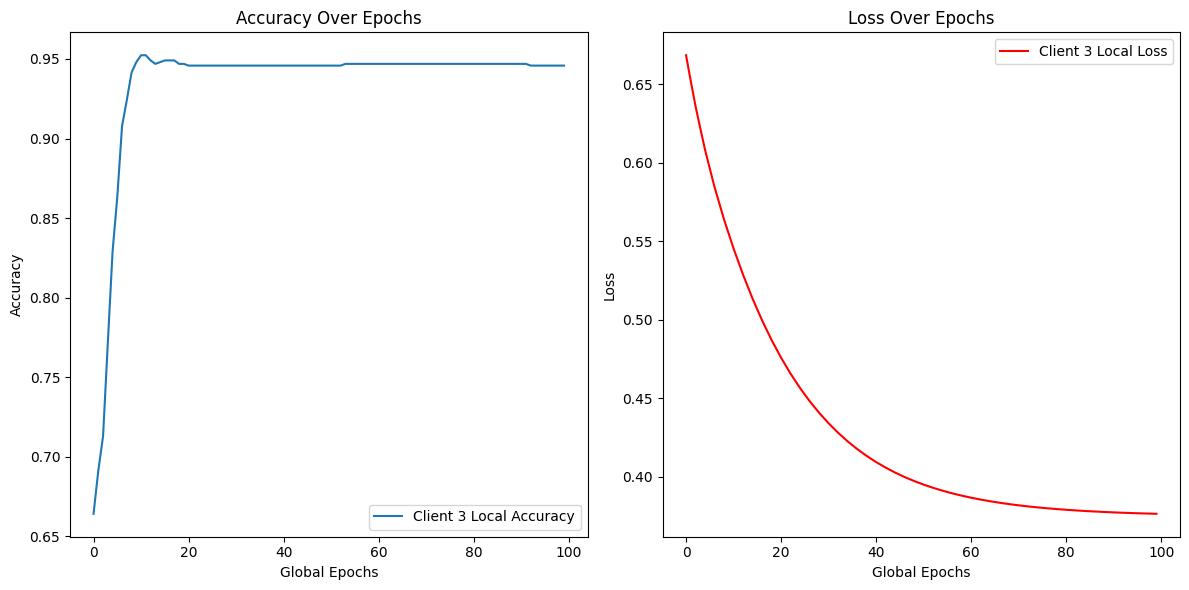

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)


# Function to evaluate accuracy
def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

#  local model training class
class LocalModel:
    def __init__(self, model, file_path, lr=0.0001):
        self.model = model
        self.lr = lr
        self.file_path = file_path
        self.scaler = None

        df = pd.read_csv(file_path)
        X = df.drop('Label', axis=1)
        y = df['Label']

        # Initialize LabelEncoder to convert categorical data into numeric labels
        le = LabelEncoder()

        # 1. Process categorical features (if any) in the feature matrix X
        for column in X.columns:
            # Check if the column is categorical (i.e., object data type)
            if X[column].dtype == 'object':
                # Step 1a: Handle missing values by filling them with 'Unknown'
                X[column] = X[column].fillna('Unknown')
                # Step 1b: Encode categorical values as numeric labels
                X[column] = le.fit_transform(X[column].astype(str))  # Ensure values are treated as strings before encoding

        # 2. Impute missing values in numerical columns with the median value of each column
        num_columns = X.select_dtypes(include=['int64', 'float64']).columns  # Select numerical columns (int or float)

        # Initialize SimpleImputer to fill missing values with the median strategy
        imputer = SimpleImputer(strategy='median')
        # Apply the imputer to numerical columns and replace missing values
        X[num_columns] = imputer.fit_transform(X[num_columns])

        # 3. Standardize numerical features: Scale them to have mean=0 and variance=1
        scaler = StandardScaler()
        # Scale all columns of X (this will affect both categorical and numerical columns)
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        # 4. Encode the target variable y (if categorical)
        # Convert categorical labels into numeric values (e.g., 'Benign' -> 0, 'Malicious' -> 1)
        y = le.fit_transform(y)  # We use the same encoder to ensure consistency between X and y encoding


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.LongTensor(y_test)

        self.X_train = X_train_tensor
        self.y_train = y_train_tensor
        self.X_test = X_test_tensor
        self.y_test = y_test_tensor

    def train(self, epochs=100):
        accuracies = []
        losses = []  # Track the global loss over epochs
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

        # Training loop
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train)
            loss = criterion(outputs, self.y_train)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = evaluate_accuracy(self.model, self.X_test, self.y_test)
            accuracies.append(accuracy)
            losses.append(loss.item())


        return accuracies, losses

if __name__ == "__main__":

    file_path = '/content/drive/MyDrive/5G-SliciNdd/cleaned/mMTC_cleaned.csv'

    # MLP model configuration
    input_size = 17  # Adjust based on your dataset
    output_size = 2  # Adjust for the number of classes
    hidden_sizes = [100, 50]  # Example hidden layer sizes

    # Initialize the MLP model
    model = MLP(input_size, hidden_sizes, output_size).to(device)

    # Initialize the local training object
    client3_model = LocalModel(model, file_path, lr=0.001)

    # Train the model and get the accuracy results
    client3_accuracies, client3_losses = client3_model.train(epochs=100)


    print("\n--- Client 3 Local Accuracies ---")
    for epoch, accuracy in enumerate(client3_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- Client 3 Local Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(client3_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"Client 3 Local Final Accuracy = {client3_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"Client 3 Local Average Loss over all epochs: {total_loss / len(client3_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(client3_accuracies, label='Client 3 Local Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(client3_losses, label='Client 3 Local Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **-----------------------------Centralised Model---------------------------------**


--- Centralised Accuracies ---
Global Epoch 1: Accuracy = 0.5208
Global Epoch 2: Accuracy = 0.5567
Global Epoch 3: Accuracy = 0.6208
Global Epoch 4: Accuracy = 0.6658
Global Epoch 5: Accuracy = 0.7075
Global Epoch 6: Accuracy = 0.7958
Global Epoch 7: Accuracy = 0.8283
Global Epoch 8: Accuracy = 0.8375
Global Epoch 9: Accuracy = 0.8392
Global Epoch 10: Accuracy = 0.8408
Global Epoch 11: Accuracy = 0.8417
Global Epoch 12: Accuracy = 0.8583
Global Epoch 13: Accuracy = 0.8600
Global Epoch 14: Accuracy = 0.8650
Global Epoch 15: Accuracy = 0.8708
Global Epoch 16: Accuracy = 0.8758
Global Epoch 17: Accuracy = 0.8842
Global Epoch 18: Accuracy = 0.8892
Global Epoch 19: Accuracy = 0.8892
Global Epoch 20: Accuracy = 0.8883
Global Epoch 21: Accuracy = 0.8908
Global Epoch 22: Accuracy = 0.8917
Global Epoch 23: Accuracy = 0.8958
Global Epoch 24: Accuracy = 0.8975
Global Epoch 25: Accuracy = 0.9017
Global Epoch 26: Accuracy = 0.9025
Global Epoch 27: Accuracy = 0.9033
Global Epoch 28: Accuracy = 0.90

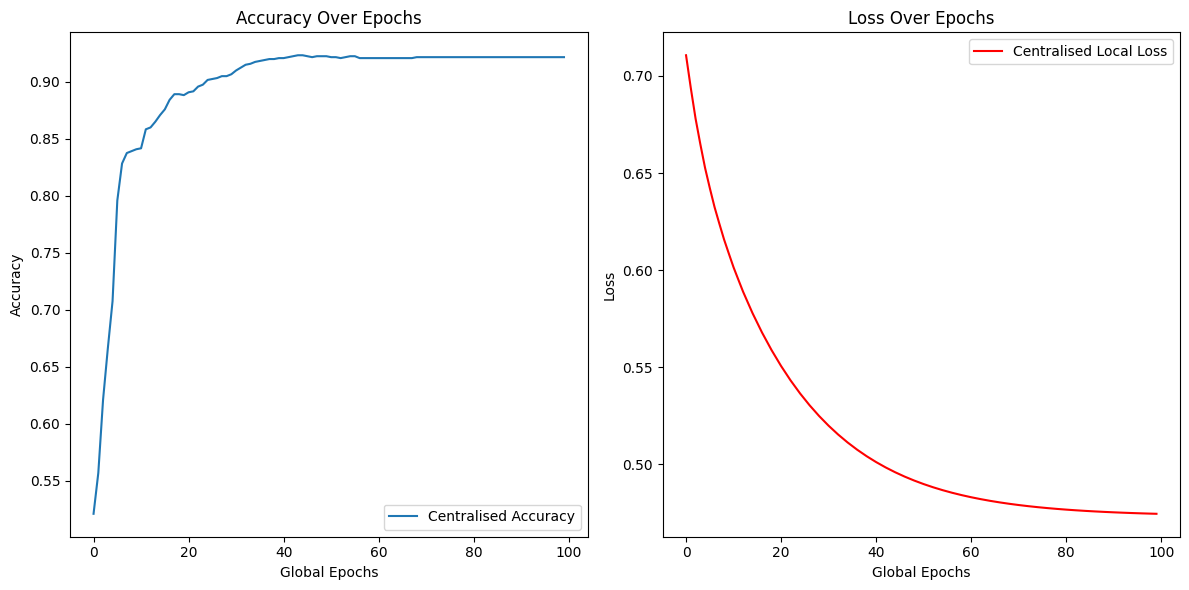

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)


# Function to evaluate accuracy
def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

#  local model training class
class LocalModel:
    def __init__(self, model, file_path, lr=0.0001):
        self.model = model
        self.lr = lr
        self.file_path = file_path
        self.scaler = None

        df = pd.read_csv(file_path)
        X_big = df.drop('Label', axis=1)
        y_big = df['Label']
        # Perform stratified sampling
        X, _, y, _ = train_test_split(X_big, y_big, train_size=6000, stratify=y_big, random_state=42)

        # Initialize LabelEncoder to convert categorical data into numeric labels
        le = LabelEncoder()

        # 1. Process categorical features (if any) in the feature matrix X
        for column in X.columns:
            # Check if the column is categorical (i.e., object data type)
            if X[column].dtype == 'object':
                # Step 1a: Handle missing values by filling them with 'Unknown'
                X[column] = X[column].fillna('Unknown')
                # Step 1b: Encode categorical values as numeric labels
                X[column] = le.fit_transform(X[column].astype(str))  # Ensure values are treated as strings before encoding

        # 2. Impute missing values in numerical columns with the median value of each column
        num_columns = X.select_dtypes(include=['int64', 'float64']).columns  # Select numerical columns (int or float)

        # Initialize SimpleImputer to fill missing values with the median strategy
        imputer = SimpleImputer(strategy='median')
        # Apply the imputer to numerical columns and replace missing values
        X[num_columns] = imputer.fit_transform(X[num_columns])

        # 3. Standardize numerical features: Scale them to have mean=0 and variance=1
        scaler = StandardScaler()
        # Scale all columns of X (this will affect both categorical and numerical columns)
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        # 4. Encode the target variable y (if categorical)
        # Convert categorical labels into numeric values (e.g., 'Benign' -> 0, 'Malicious' -> 1)
        y = le.fit_transform(y)  # We use the same encoder to ensure consistency between X and y encoding


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.LongTensor(y_test)

        self.X_train = X_train_tensor
        self.y_train = y_train_tensor
        self.X_test = X_test_tensor
        self.y_test = y_test_tensor

    def train(self, epochs=100):
        accuracies = []
        losses = []  # Track the global loss over epochs
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

        # Training loop
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train)
            loss = criterion(outputs, self.y_train)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = evaluate_accuracy(self.model, self.X_test, self.y_test)
            accuracies.append(accuracy)
            losses.append(loss.item())


        return accuracies, losses

if __name__ == "__main__":

    file_path = '/content/drive/MyDrive/5G-SliciNdd/cleaned3/Global_cleaned.csv'

    # MLP model configuration
    input_size = 17  # Adjust based on your dataset
    output_size = 2  # Adjust for the number of classes
    hidden_sizes = [100, 50]  # Example hidden layer sizes

    # Initialize the MLP model
    model = MLP(input_size, hidden_sizes, output_size).to(device)

    # Initialize the local training object
    cent_model = LocalModel(model, file_path, lr=0.001)

    # Train the model and get the accuracy results
    cent_accuracies, cent_losses = cent_model.train(epochs=100)


    print("\n--- Centralised Accuracies ---")
    for epoch, accuracy in enumerate(cent_accuracies, start=1):
        print(f"Global Epoch {epoch}: Accuracy = {accuracy:.4f}")

    print("\n--- Centralised Loss ---")
    total_loss = 0
    for epoch, loss in enumerate(cent_losses, start=1):
        print(f"Global Epoch {epoch}: Loss = {loss:.4f}")
        total_loss += loss

    print("\n-------------------")
    print(f"Centralised Final Accuracy = {cent_accuracies[-1]:.4f}")

    print("\n-------------------")
    print(f"Centralised Average Loss over all epochs: {total_loss / len(cent_losses):.4f}")



    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(cent_accuracies, label='Centralised Accuracy')
    plt.xlabel('Global Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(cent_losses, label='Centralised Local Loss', color='red')
    plt.xlabel('Global Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **----------------------------------------Performance----------------------------------------**

## **Accuracy**

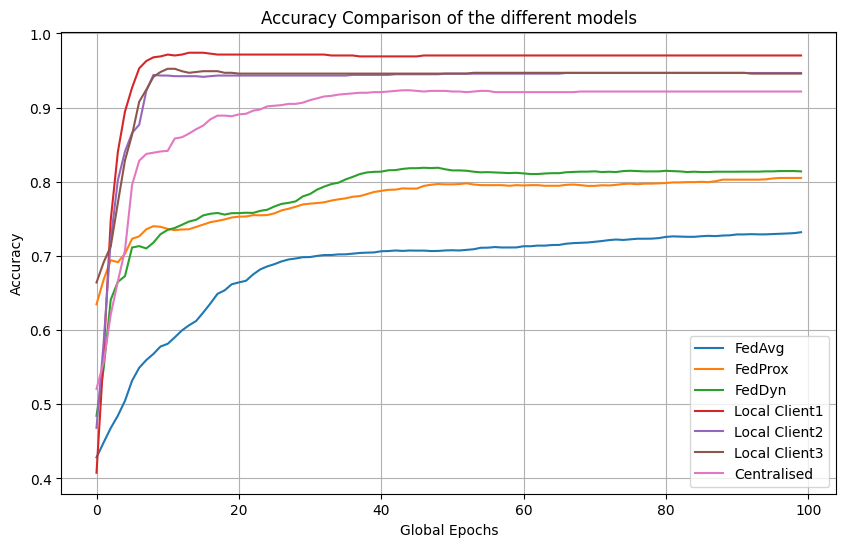

In [ ]:
# Plotting the accuracies on the same graph
plt.figure(figsize=(10, 6))

# Plot each model's accuracy
plt.plot(fedavg_accuracies, label='FedAvg')
plt.plot(fedprox_accuracies, label='FedProx')
plt.plot(feddyn_accuracies, label='FedDyn')
plt.plot(client1_accuracies, label='Local Client1')
plt.plot(client2_accuracies, label='Local Client2')
plt.plot(client3_accuracies, label='Local Client3')
plt.plot(cent_accuracies, label='Centralised')



# Adding labels and title
plt.xlabel('Global Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of the different models')
plt.legend()  # To show the labels in the graph

# Optional: Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

## **Loss**

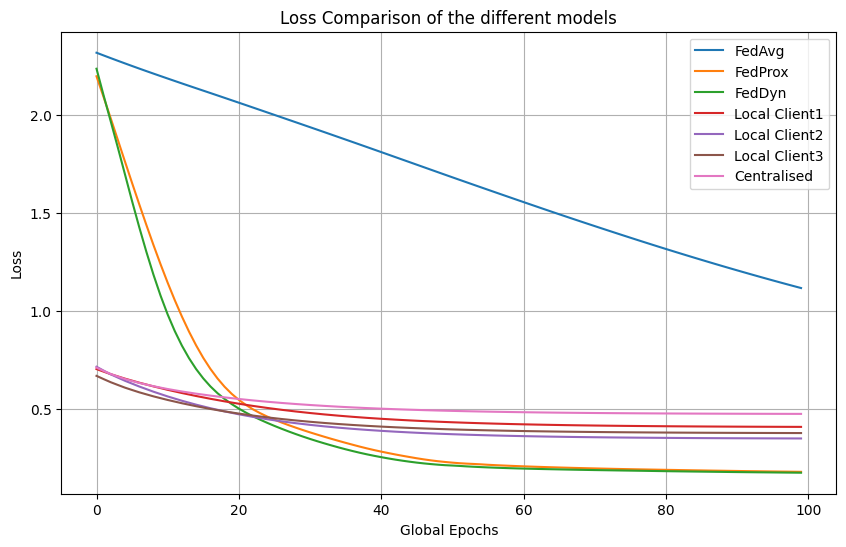

In [ ]:
# Plotting the losses on the same graph
plt.figure(figsize=(10, 6))

# Plot each model's loss
plt.plot(fedavg_losses, label='FedAvg')
plt.plot(fedprox_losses, label='FedProx')
plt.plot(feddyn_losses, label='FedDyn')
plt.plot(client1_losses, label='Local Client1')
plt.plot(client2_losses, label='Local Client2')
plt.plot(client3_losses, label='Local Client3')
plt.plot(cent_losses, label='Centralised')



# Adding labels and title
plt.xlabel('Global Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison of the different models')
plt.legend()  # To show the labels in the graph

# Optional: Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()